<a href="https://colab.research.google.com/github/Lois-Lanctot/student-performance-analysis/blob/main/student_performance_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [178]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import pointbiserialr, f_oneway

!pip3 install ppscore
import ppscore as pps


In [179]:
# changes catagorical columns into numerical columns using One-Hot Encoding
def create_preprocessor(features):
    return ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), features)
        ],
        remainder='passthrough'
    )


# trains a ML model using a pipline and evaluates it's performance
def train_and_evaluate_model(model, model_name, features):
    preprocessor = create_preprocessor(features)

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Evaluate the model performance using MAE (Mean Absolute Error) and RMSE (Root Mean Squared Error)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae_scores[model_name] = mae
    rmse_scores[model_name] = rmse


# exams.csv

3 highschools in the US

In [180]:
# read exams.csv into a DataFrame
exams_df = pd.read_csv("/content/exams.csv")
exams_df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group D,some college,standard,completed,59,70,78
1,male,group D,associate's degree,standard,none,96,93,87
2,female,group D,some college,free/reduced,none,57,76,77
3,male,group B,some college,free/reduced,none,70,70,63
4,female,group D,associate's degree,standard,none,83,85,86


In [181]:
# print exams.csv info
exams_df.info()
print("Columns: ", exams_df.columns)
print("Record Count: ", len(exams_df))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB
Columns:  Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'math score', 'reading score',
       'writing score'],
      dtype='object')
Record Count:  1000


In [182]:
# check if there are any null values
print(exams_df.isnull().sum())

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64


In [183]:
# print unique values for the catagorical columns
print(exams_df['gender'].unique())
print(exams_df['race/ethnicity'].unique())
print(exams_df['parental level of education'].unique())
print(exams_df['lunch'].unique())
print(exams_df['test preparation course'].unique())

['female' 'male']
['group D' 'group B' 'group C' 'group E' 'group A']
['some college' "associate's degree" 'some high school'
 "bachelor's degree" "master's degree" 'high school']
['standard' 'free/reduced']
['completed' 'none']


In [184]:
# visulaize the distribution of the catagorical columns
categorical_cols = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']

# for col in categorical_cols:
#     plt.figure(figsize=(6, 4))
#     sns.countplot(exams_df[col])
#     plt.title(f'Distribution of {col}')
#     plt.show()


In [185]:
# visulaize the distribution of the numerical columns
numerical_cols = ['math score', 'reading score', 'writing score']
# for col in numerical_cols:
#     plt.figure(figsize=(6, 4))
#     sns.histplot(exams_df[col], kde=True)
#     plt.title(f'Distribution of {col}')
#     plt.show()

#     sns.boxplot(x=exams_df[col])
#     plt.title(f'Box plot of {col}')
#     plt.show()


In [186]:
# remove outliers
columns_to_check = [
    'gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'math score', 'reading score',
       'writing score'
]
z_scores = stats.zscore(exams_df[columns_to_check].select_dtypes(include=['float64', 'int64']), nan_policy='omit')
exams_df = exams_df[(abs(z_scores) < 3).all(axis=1)]

In [187]:
# analyze the relationship between gender and scores
# for col in numerical_cols:
#     plt.figure(figsize=(6, 4))
#     sns.boxplot(x='gender', y=col, data=exams_df)
#     plt.title(f'{col} by Gender')
#     plt.show()


In [188]:
# analyze the relationship between parental education and scores
# for col in numerical_cols:
#     plt.figure(figsize=(6, 4))
#     sns.boxplot(x='parental level of education', y=col, data=exams_df)
#     plt.xticks(rotation=45)
#     plt.title(f'{col} by Parental Level of Education')
#     plt.show()


In [189]:
# analyze the relationship between test preparation course completion and scores
# for col in numerical_cols:
#     plt.figure(figsize=(6, 4))
#     sns.boxplot(x='test preparation course', y=col, data=exams_df)
#     plt.title(f'{col} by Test Preparation Course')
#     plt.show()


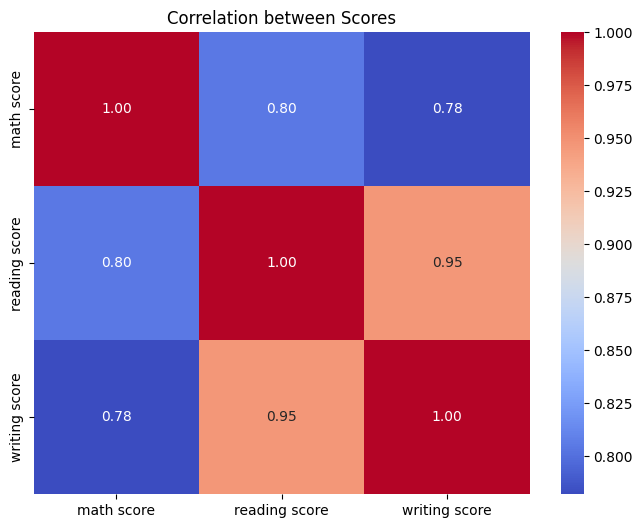

In [190]:
# create a correlation heatmap between scores
plt.figure(figsize=(8, 6))
sns.heatmap(exams_df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation between Scores')
plt.show()


In [210]:
# calcualte the correlation of the numerical columns
target = 'reading score'

numerical_data = exams_df.select_dtypes(include=['float64', 'int64'])

correlation_matrix = numerical_data.corr()

correlation = correlation_matrix[target].abs().sort_values(ascending=False)
print(correlation)


reading score    1.000000
writing score    0.946702
math score       0.804398
Name: reading score, dtype: float64


In [213]:
# select features and split the data into train/test
features = ['writing score', 'math score']

X = exams_df[features]
y = exams_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mae_scores = {}
rmse_scores = {}

In [214]:
# Linear Regression
linear_model = LinearRegression()
train_and_evaluate_model(linear_model, 'Linear Regression', features)

# Decision Tree
tree_model = DecisionTreeRegressor(random_state=42)
train_and_evaluate_model(tree_model, 'Decision Tree', features)

# Random Forest
rf_model = RandomForestRegressor(random_state=42)
train_and_evaluate_model(rf_model, 'Random Forest', features)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [218]:
# print the range of the target
print(f"Range of {target}: {exams_df[target].min():.0f}-{exams_df[target].max():.0f}")

# print all MAE and RMSE scores with error percentages
for model_name in mae_scores:
    mae = mae_scores[model_name]
    mae_percentage_error = (mae / y_test.mean()) * 100
    print(f"{model_name}: MAE = {mae:.2f} (Error %: {mae_percentage_error:.2f}%), RMSE = {rmse_scores[model_name]:.2f} (Error %: {(rmse_scores[model_name] / y_test.mean()) * 100:.2f}%)")

Range of reading score: 32-100
Linear Regression: MAE = 3.63 (Error %: 5.12%), RMSE = 4.54 (Error %: 6.40%)
Decision Tree: MAE = 4.50 (Error %: 6.34%), RMSE = 5.71 (Error %: 8.04%)
Random Forest: MAE = 3.95 (Error %: 5.57%), RMSE = 5.14 (Error %: 7.25%)


# student_data



Secondary education of two Portuguese schools

In [195]:
large_df = pd.read_csv("/content/student_data.csv")
large_df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [196]:
# large_df.info()
print("Columns: ", large_df.columns)
print("Record Count: ", len(large_df))

Columns:  Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')
Record Count:  395


In [197]:
# print(large_df.isnull().sum())

In [198]:
categorical_cols = [
    'school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob',
    'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities',
    'nursery', 'higher', 'internet', 'romantic'
]

# for col in categorical_cols:
#     plt.figure(figsize=(6, 4))
#     sns.countplot(large_df[col])
#     plt.title(f'Distribution of {col}')
#     plt.show()


In [199]:
numerical_cols = [
    'age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
    'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

# for col in numerical_cols:
#     plt.figure(figsize=(6, 4))
#     sns.histplot(large_df[col])
#     plt.title(f'Distribution of {col}')
#     plt.show()

#     sns.boxplot(x=large_df[col])
#     plt.title(f'Box plot of {col}')
#     plt.show()


In [200]:
grad_mean = (large_df.G1 + large_df.G2 + large_df.G3) / 3
large_df['G_Mean'] = grad_mean
large_df.drop(columns=['G1', 'G2', 'G3'], inplace=True)
large_df.head(4)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G_Mean
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,no,4,3,4,1,1,3,6,5.666667
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,no,5,3,3,1,1,3,4,5.333333
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,no,4,3,2,2,3,3,10,8.333333
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,3,2,2,1,1,5,2,14.666667


In [201]:
# # categorical versus average grade
# for col in categorical_cols:
#     plt.figure(figsize=(8, 5))
#     sns.boxplot(x=col, y='G_Mean', data=large_df)
#     plt.title(f'Grade by {col}')
#     plt.xticks(rotation=45)
#     plt.show()


In [202]:
# # numerical versus average grade
# for col in numerical_cols:
#     plt.figure(figsize=(6, 4))
#     sns.scatterplot(x=col, y='G_Mean', data=large_df)
#     plt.title(f'Grade vs {col}')
#     plt.show()


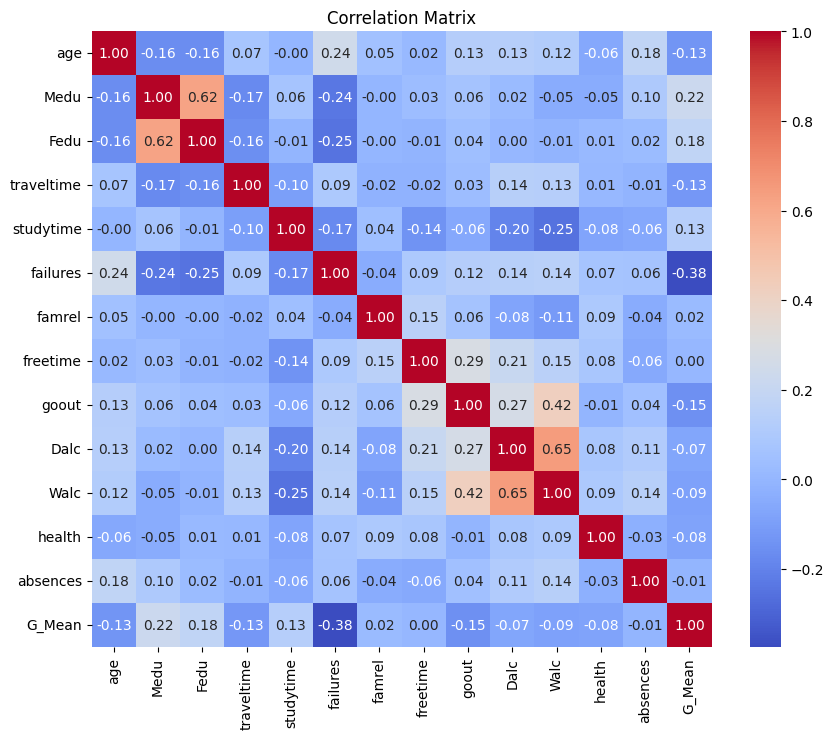

G_Mean        1.000000
failures      0.375759
Medu          0.224260
Fedu          0.175852
goout         0.154511
age           0.134589
studytime     0.134565
traveltime    0.128197
Walc          0.088025
health        0.080380
Dalc          0.072508
famrel        0.021653
absences      0.005909
freetime      0.003773
Name: G_Mean, dtype: float64


In [203]:
# Correlation heatmap
numerical_data = large_df.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(10, 8))
sns.heatmap(numerical_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


correlation_matrix = numerical_data.corr()
correlation = correlation_matrix['G_Mean'].abs().sort_values(ascending=False)
print(correlation)


In [204]:
# Calculate the Python Predictive Power Score (PPS) only for 'G_Mean' as the target
target = 'G_Mean'
pps_scores = []

for feature in large_df.columns:
    if feature != target:  # Skip the target column itself
        score = pps.score(large_df, feature, target)
        # Append all relevant details from the score dictionary
        pps_scores.append({
            'x': feature,
            'y': target,
            'ppscore': score['ppscore'],
              'case': score['case'],
            'model': score.get('model', None),
            'model_score': score.get('model_score', None),
            'baseline_score': score.get('baseline_score', None),
            'comparison': score.get('comparison', None)
        })

# Convert the results into a DataFrame
pps_df = pd.DataFrame(pps_scores)

# Display the DataFrame with only ppscores above 0
pps_df.loc[pps_df['ppscore'] != 0]

,x,y,ppscore,case,model,model_score,baseline_score,comparison
1,sex,G_Mean,0.003891,regression,DecisionTreeRegressor(),2.964791,2.976371,None
3,address,G_Mean,0.001984,regression,DecisionTreeRegressor(),2.970465,2.976371,None
6,Medu,G_Mean,0.012898,regression,DecisionTreeRegressor(),2.937982,2.976371,None
7,Fedu,G_Mean,0.020843,regression,DecisionTreeRegressor(),2.914336,2.976371,None
8,Mjob,G_Mean,0.001996,regression,DecisionTreeRegressor(),2.970430,2.976371,None
12,traveltime,G_Mean,0.003490,regression,DecisionTreeRegressor(),2.965983,2.976371,None
14,failures,G_Mean,0.057588,regression,DecisionTreeRegressor(),2.804967,2.976371,None
15,schoolsup,G_Mean,0.020280,regression,DecisionTreeRegressor(),2.916011,2.976371,None
20,higher,G_Mean,0.012352,regression,DecisionTreeRegressor(),2.939608,2.976371,None
21,internet,G_Mean,0.002477,regression,DecisionTreeRegressor(),2.968999,2.976371,None


In [205]:
# select features
features = ['Medu', 'Fedu', 'studytime', 'failures', 'goout', 'age', 'traveltime']
# features = ['Pstatus', 'Fjob', 'reason', 'guardian', 'famsup', 'paid', 'activities', 'romantic']

X = large_df[features]
y = large_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mae_scores = {}
rmse_scores = {}

In [206]:
# For Linear Regression
linear_model = LinearRegression()
train_and_evaluate_model(linear_model, 'Linear Regression', features)

# For Decision Tree
tree_model = DecisionTreeRegressor(random_state=42)
train_and_evaluate_model(tree_model, 'Decision Tree', features)

# For Random Forest
rf_model = RandomForestRegressor(random_state=42)
train_and_evaluate_model(rf_model, 'Random Forest', features)

In [207]:
# Print the range of G_Mean
print(f"Range of {target} score: {large_df[target].min():.2f} - {large_df[target].max():.2f}")


# Print all MAE and RMSE scores with error percentages in a concise format
for model_name in mae_scores:
    mae = mae_scores[model_name]
    mae_percentage_error = (mae / y_test.mean()) * 100
    print(f"{model_name}: MAE = {mae:.2f} (Error %: {mae_percentage_error:.2f}%), RMSE = {rmse_scores[model_name]:.2f} (Error %: {(rmse_scores[model_name] / y_test.mean()) * 100:.2f}%)")


Range of G_Mean score: 1.33 - 19.33
Linear Regression: MAE = 3.09 (Error %: 28.50%), RMSE = 3.68 (Error %: 33.88%)
Decision Tree: MAE = 3.69 (Error %: 34.04%), RMSE = 4.67 (Error %: 43.08%)
Random Forest: MAE = 3.24 (Error %: 29.88%), RMSE = 3.91 (Error %: 36.02%)
